In [1]:
import sys                       
sys.path.append('../scripts/')
from ideal_robot import *
from scipy.stats import expon, norm

In [2]:
class Robot(IdealRobot): ###biased_random_robot### noiseメソッドは省略で
        
    def __init__(self, pose, agent=None, sensor=None, color="black",
                 noise_per_meter=5, noise_std=math.pi/60,
                 bias_rate_stds=(0.1,0.1)):  #引数bias_rate_stdsを追加
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])          #追加
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1])  #追加
    
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise -= nu*time_interval + self.r*omega*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
            
        return pose
    
    def bias(self, nu, omega):  #追加
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
        
    def one_step(self, time_interval):
        if not self.agent: return
        obs =self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)  #追加
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, omega, nu, time_interval)

<IPython.core.display.Javascript object>


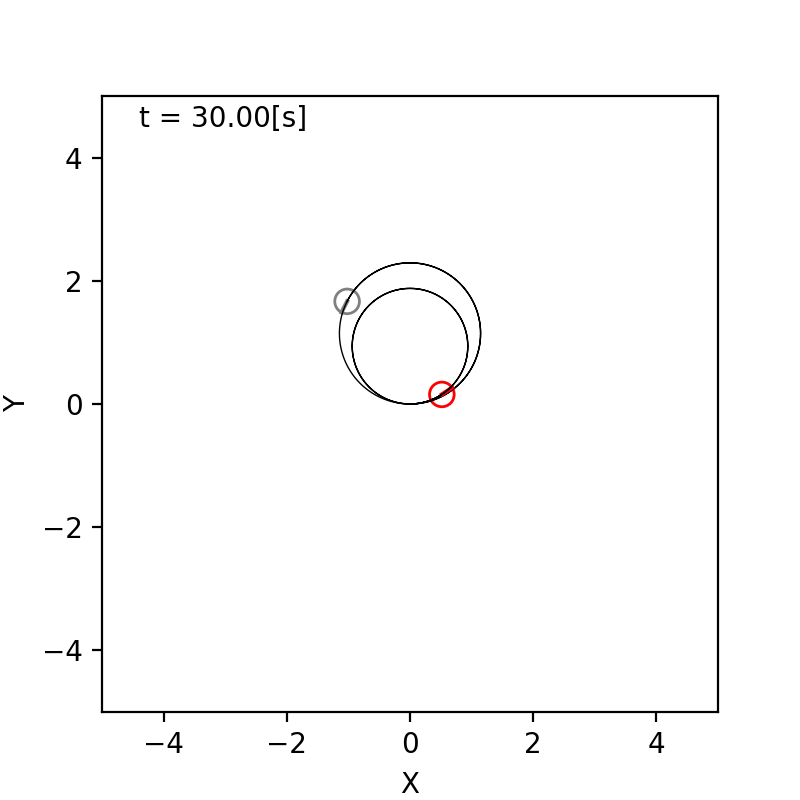

In [8]:
import copy  ###compare_nobias_bias###

world = World(30, 0.1) 

circling = Agent(0.2, 10.0/180*math.pi)    
nobias_robot = IdealRobot( np.array([0, 0, 0]).T, sensor=None, agent=circling, color="gray")
world.append(nobias_robot)
biased_robot = Robot( np.array([0, 0, 0]).T, sensor=None, agent=circling,
                     color="red", noise_per_meter=0, bias_rate_stds=(0.2,0.2))
world.append(biased_robot)

world.draw()
world.ani.save('/tmp/anm.gif', writer='imagemagick', fps=1)